In [1]:
# Thoomas Goldman 2023
# DOLPHINN

import sys
import os
import matplotlib.pyplot as plt

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
# from DOLPHINN.dynamics import TwoBodyProblemRadialNonDimensionalControl
# from DOLPHINN.output_layers import InitialFinalStateLayer_Radial
# from DOLPHINN.training import Scheduler, Restarter
# from DOLPHINN.objectives import OptimalFuel
import DOLPHINN.plotting as plotting

import numpy as np

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
problem2 = DOLPHINN.from_solution("../Data/test/", verbose = True)

[DOLPHINN] Initializing the DOLPHINN from old solution at: ../Data/test/
[DOLPHINN][Warning] Upload of seed requested: initialisation will be overwritten by the solution
[DOLPHINN] Config file succesfully parsed. Initializing DOLPHINN with:

 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensionalControl
input_transform                None
output_transform               InitialFinalStateLayer_Radial
objective                      OptimalFuel

----------Problem----------
initial_state                  [1.0, 0.0, 1.0]
final_state                    [1.5, 0.0, 0.816496580927726]
mu                             1.32712440042e+20
m                              100
a                              10
umax                           1
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.305393074
t0                             0
tfin

Test fuel:  12.28  kg 


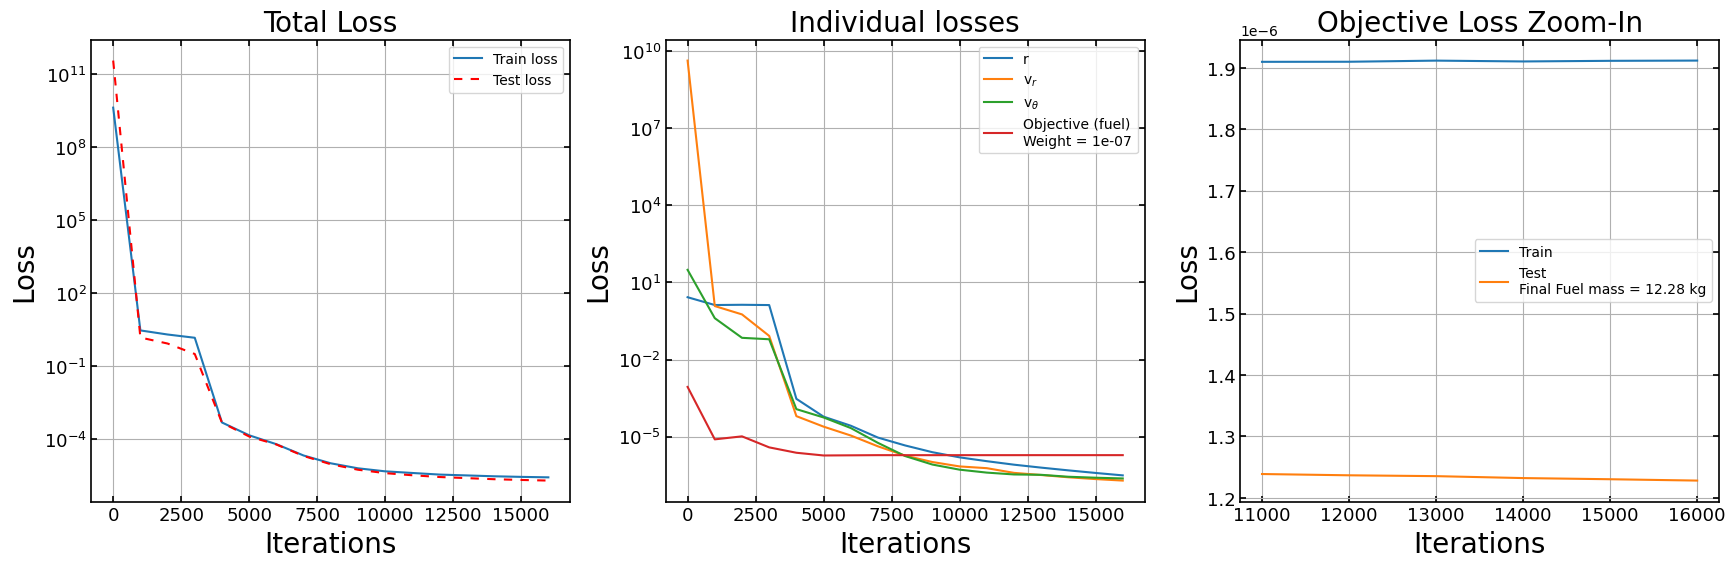

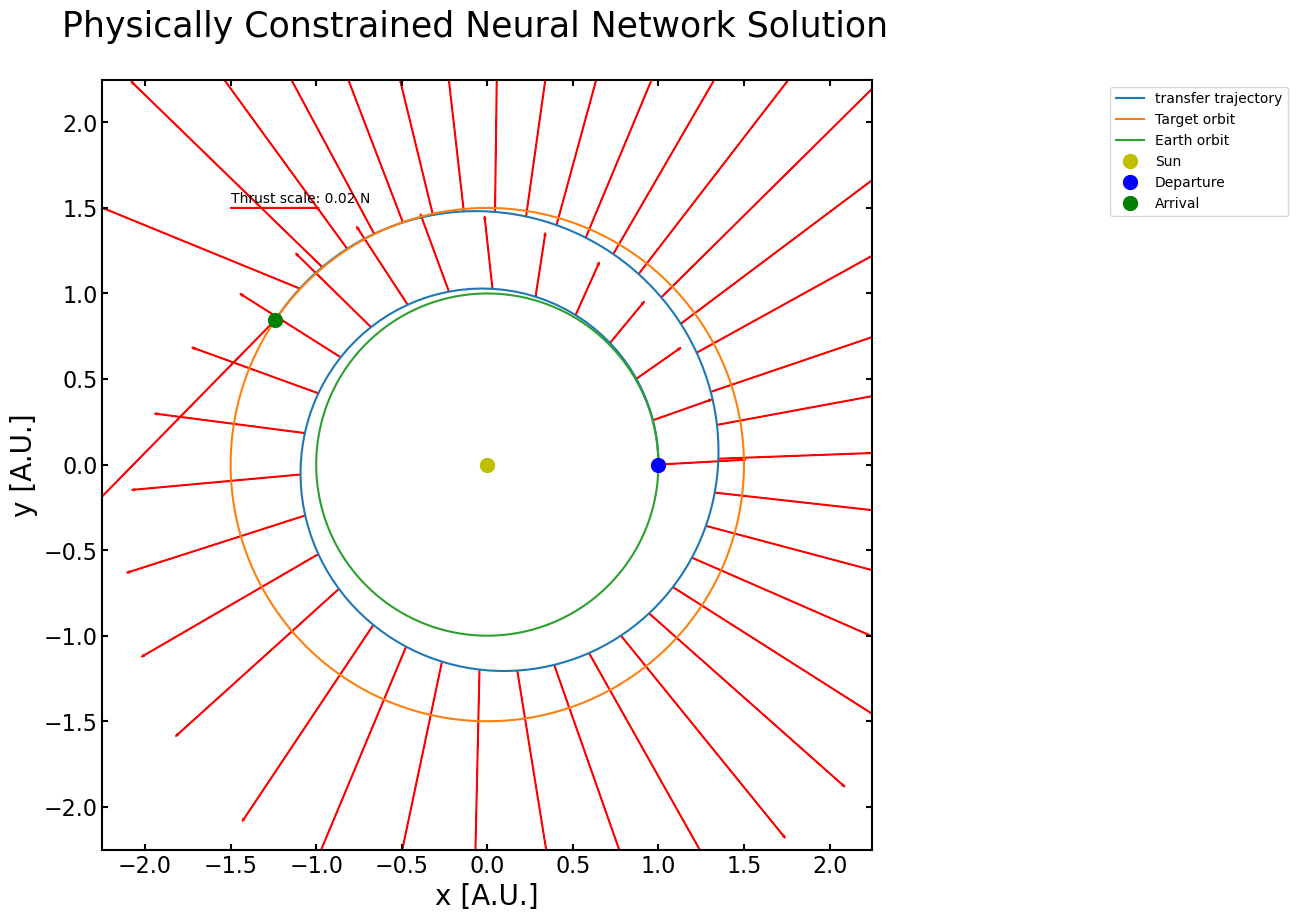

In [9]:
plotting.plot_loss(problem2)  
plotting.plot_transfer(problem2)